1. Для нашего пайплайна поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import FeatureUnion
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Cтроим модель

In [3]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [4]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [5]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [6]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Теперь нам нужно под каждый признак создать трансформер и объединить их в список

In [7]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [8]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Добавим модель

#### Logistic regression

In [9]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(C=0.1,  random_state=24)),
])

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Geography',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography')),
                                                                 ('standard',
                                                                  StandardScaler(copy=True,
                                                                                 with_mean=True,
                                                                                 with_std=True))],
                                                        

In [10]:
preds_lr = pipeline.predict_proba(X_test)[:, 1]
preds_lr[:-10]

array([0.22380996, 0.33854007, 0.18443285, ..., 0.21424472, 0.33070438,
       0.07862211])

In [11]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_lr)
fscore = (2 * precision * recall) / (precision + recall)
fscore = np.nan_to_num(fscore)
ix_lr = np.argmax(fscore)
fscore_lr = fscore[ix_lr]
precision_lr = precision[ix_lr]
recall_lr = recall[ix_lr]

roc_auc_score_lr = roc_auc_score(y_test, preds_lr)

#### XGBoost

In [12]:
import xgboost as xgb

pipeline_xgb = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBClassifier(max_depth=5, n_estimators=100, random_state=42, reg_alpha=0.1, reg_lambda=1e-3)),
])

In [13]:
#обучим наш пайплайн
pipeline_xgb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Geography',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography')),
                                                                 ('standard',
                                                                  StandardScaler(copy=True,
                                                                                 with_mean=True,
                                                                                 with_std=True))],
                                                        

In [14]:
#наши прогнозы для тестовой выборки
preds = pipeline_xgb.predict_proba(X_test)[:, 1]
preds[:10]

array([0.4735598 , 0.30615717, 0.18960151, 0.07835434, 0.05621345,
       0.84078604, 0.05933473, 0.08448657, 0.04415148, 0.74001336],
      dtype=float32)

In [15]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

In [16]:
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
fscore_xgb = fscore[ix]
precision_xgb = precision[ix]
recall_xgb = recall[ix]

roc_auc_score_xgb = roc_auc_score(y_test, preds)

#### Посмотрим на метрики для моделей

In [17]:
table = pd.DataFrame(data={'Metrics':['Precision', 'Recall', 'F-score', 'Roc_auc_score'],
                           'XGBoost':[precision_xgb, recall_xgb, fscore_xgb, roc_auc_score_xgb],
                          'Logistic regression':[precision_lr, recall_lr, fscore_lr, roc_auc_score_lr]}, dtype=np.float, index=None) 
table = table.set_index('Metrics')
table

,XGBoost,Logistic regression
Metrics,,
Precision,0.613767,0.296808
Recall,0.630648,0.675835
F-score,0.622093,0.412470
Roc_auc_score,0.861258,0.667299


Отрисуем матрицу ошибок для модели XGBoos, которая показала себя лучше

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1789  202]
 [ 189  320]]


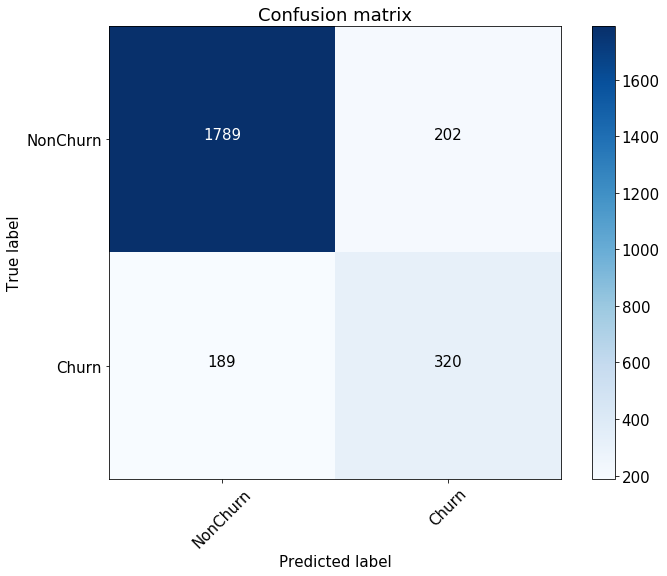

In [19]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

#### Вопрос 1: объясните своими словами смысл метрик Precison, Recall *
1. Какова их взаимосвязь и как с ними связан порог вероятности? 
2. Можно ли подобрать порог так, что recall будет равен 1? Что при этом будет с precision
3. Аналогичный вопрос про precision

Precision можно интерпретировать как долю объектов, названных классификатором положительными и при этом действительно являющимися положительными, а recall показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм. Recall демонстрирует способность алгоритма обнаруживать данный класс вообще, а precision — способность отличать этот класс от других классов.
Если подобрать порог для recall = 1, то алгоритм все объекты будет относить к положительным, при этом FP сильно вырастет и упадет TN. Если сделать precision = 1, то алгоритм будет пропускать положительный класс. Вырастет доля FN и уменьшится доля TP.

<b>Вопрос 2: предположим, что на удержание одного пользователя у нас уйдет 1 доллар. При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара. Оцените качество модели выше с учетом этих данных и ответьте на вопрос, является ли она потенциально экономически целесообразной?</b>

* TP = 320 
* FP = 202
* TN = 1789
* FN = 189

Для удержания всех, кого модель отнесла к ушедшим в отток нужно TP+FP=522 доллара. При этом средняя ожидаемая прибыль будет TP*2 = 640 долларов. 
Потенциально эта модель является экономически целесообразной. Потенциальная Выгода = 118 долларов.

Подберем гиперпараметры для модели

In [20]:
params = {'classifier__n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500], 
          'classifier__max_depth':[3, 5, 7]}

In [21]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [22]:
rs = RandomizedSearchCV(pipeline_xgb, params, scoring='f1', cv=cv, n_jobs=-1)

In [23]:
rs = rs.fit(X_train, y_train)

In [25]:
rs.best_params_

{'classifier__n_estimators': 50, 'classifier__max_depth': 3}

In [26]:
rs.best_score_

0.5772672214412627

In [27]:
pipeline_xgb = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBClassifier(max_depth=3, n_estimators=50, random_state=42, reg_alpha=0.1, reg_lambda=1e-3)),
])

In [28]:
pipeline_xgb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Geography',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography')),
                                                                 ('standard',
                                                                  StandardScaler(copy=True,
                                                                                 with_mean=True,
                                                                                 with_std=True))],
                                                        

In [29]:
preds = pipeline_xgb.predict_proba(X_test)[:, 1]
preds[:10]

array([0.25654203, 0.20810911, 0.19977804, 0.0936885 , 0.03967545,
       0.8429672 , 0.0323855 , 0.06974032, 0.19798642, 0.63597846],
      dtype=float32)

In [30]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

In [31]:
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
fscore_xgb = fscore[ix]
precision_xgb = precision[ix]
recall_xgb = recall[ix]

roc_auc_score_xgb = roc_auc_score(y_test, preds)

Отрисуем матрицу ошибок для модели XGBoos с подобранными параметрами

Confusion matrix, without normalization
[[1794  197]
 [ 177  332]]


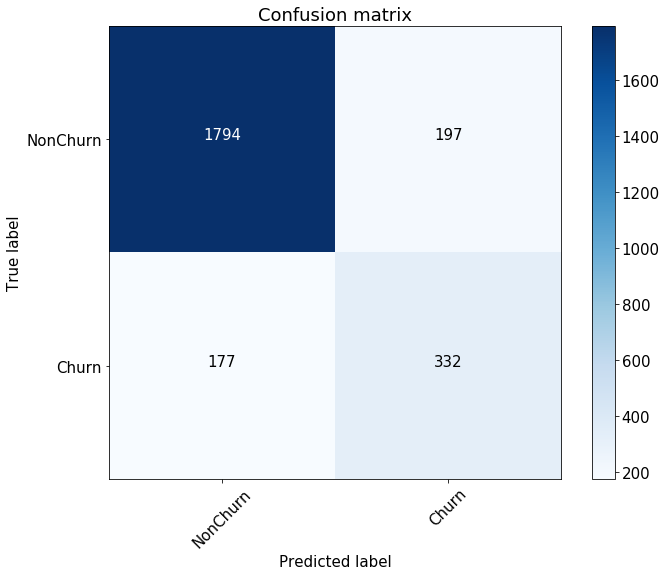

In [34]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Пересчитаем экономическую целесообразность:

* TP = 332 
* FP = 197
* TN = 1794
* FN = 177

Для удержания всех, кого модель отнесла к ушедшим в отток нужно TP+FP=529 долларов. При этом средняя ожидаемая прибыль будет TP*2 = 664 долларов. 
Потенциально эта модель является экономически целесообразной. Потенциальная прибыль = 135 доллларов (на 17 долларов больше после подбора параметров)